In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

pd.set_option('display.max_columns', 20)

In [5]:
Project_Path = Path("..").resolve()
Data_Dir = Project_Path / "data"
Model_Dir = Project_Path / "model"

<AxesSubplot:xlabel='Month'>

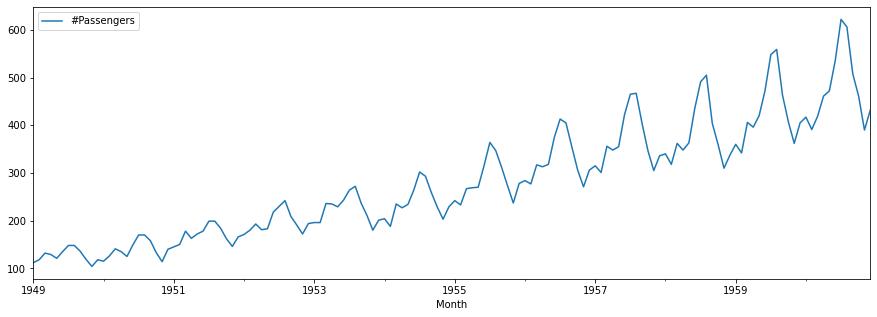

In [6]:
df_master = pd.read_csv(Data_Dir / "AirPassengers.csv", parse_dates=["Month"], index_col="Month")
df_master.plot()

# Part:1 Stationality time series

In [7]:
cd ..

c:\Users\npram\Desktop\Github\time_series


In [8]:
from app.stationality import adf_test

adf_test(df_master)

Is the time series stationary ? False
Test statistic value (adf) =  0.82
P value = 0.99
test critical value ('5%') = -2.88


### making the dataset stationality using diff (1st and 2nd etc...)

In [9]:
df_master.diff().head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


<AxesSubplot:xlabel='Month'>

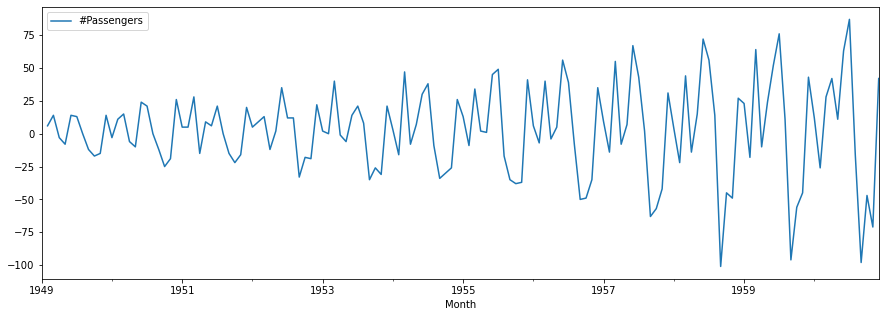

In [10]:
df_master.diff().plot()

## log

Is the time series stationary ? False
Test statistic value (adf) =  -1.72
P value = 0.42
test critical value ('5%') = -2.88


<AxesSubplot:xlabel='Month'>

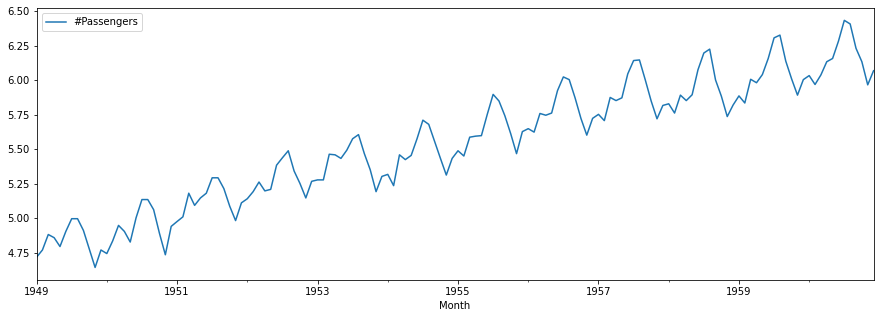

In [11]:
df_without_exponential_growth = np.log(df_master)
adf_test(df_without_exponential_growth)
df_without_exponential_growth.plot()

## 1st order diff

Is the time series stationary ? False
Test statistic value (adf) =  -2.72
P value = 0.07
test critical value ('5%') = -2.88


<AxesSubplot:xlabel='Month'>

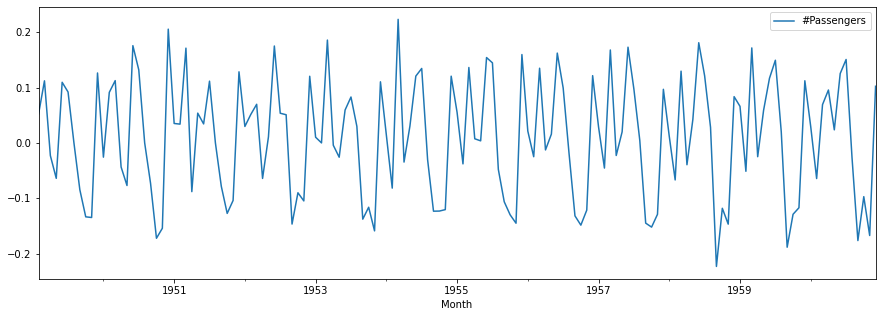

In [12]:
df_log_1_diff = df_without_exponential_growth.diff().dropna()
adf_test(df_log_1_diff)
df_log_1_diff.plot()

Is the time series stationary ? False
Test statistic value (adf) =  -2.83
P value = 0.05
test critical value ('5%') = -2.88


<AxesSubplot:xlabel='Month'>

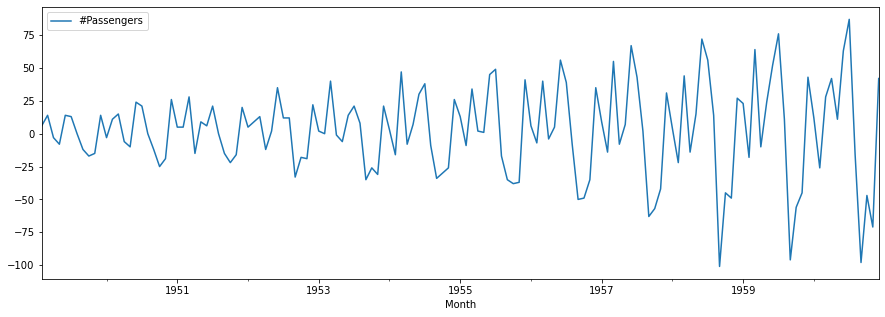

In [13]:
df_1_diff = df_master.diff().dropna()
adf_test(df_1_diff)
df_1_diff.plot()

## 2nd order diff

Is the time series stationary ? True
Test statistic value (adf) =  -2.96
P value = 0.04
test critical value ('5%') = -2.88


<AxesSubplot:xlabel='Month'>

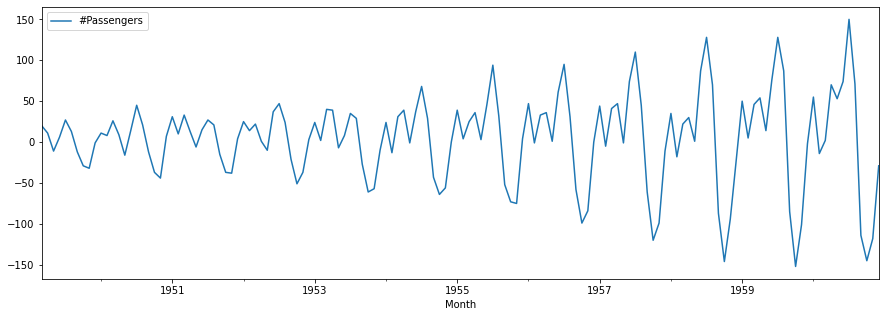

In [14]:
df_2_diff = df_master.diff(2).dropna()
adf_test(df_2_diff)
df_2_diff.plot()

* Here we can assume that the dataset is stationary becuase we got the pvalue == stationary value we declared. So "df_2_diff" == "stationary_dataset"

# part:2 Training AR model

## a. Determining the AR model from ACF and PACF plot

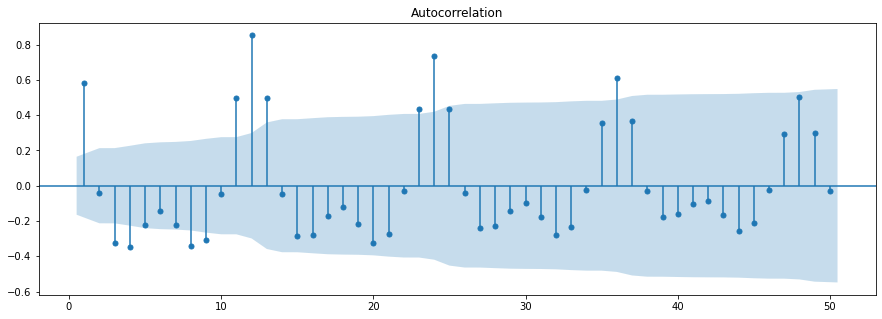

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

_ = plot_acf(df_2_diff, lags=50, zero=False)

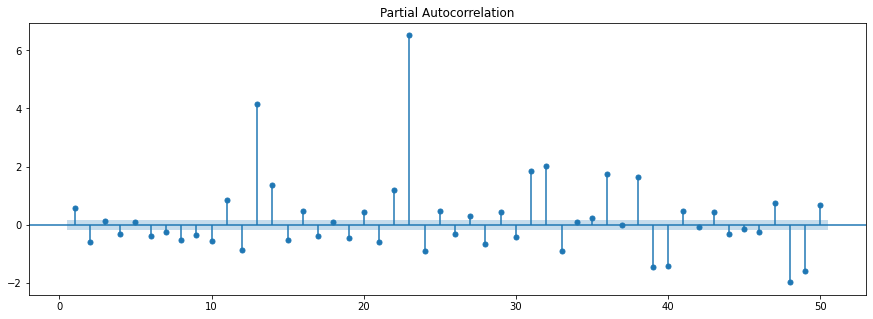

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(df_2_diff, lags=50, zero=False)

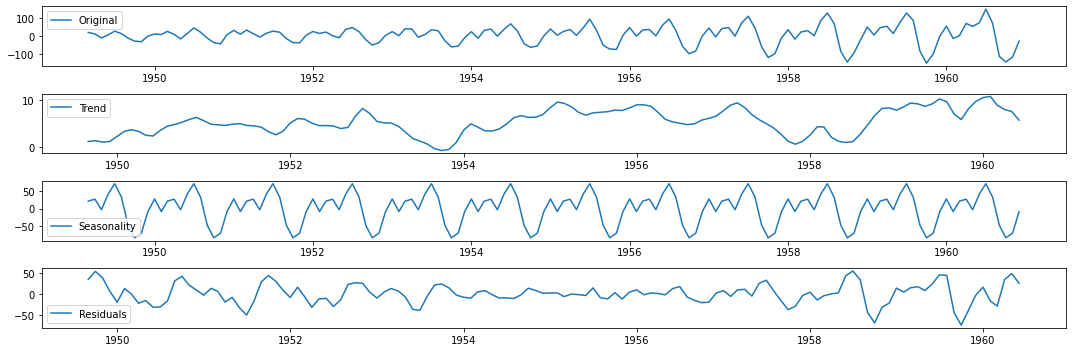

In [26]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(df_2_diff)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(df_2_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* The ACF graph shows a gradually decreasing trend while the PACF cuts immediately after one lag. Thats, the graph suggest that an AR model would be appropriate for the time series. 

* lag = 14

## b. choose the AR model order and train the model 

In [33]:
train_data = df_2_diff[:"1957-12-01"]
test_data = df_2_diff["1957-12-01":]

In [34]:
print(train_data.shape, test_data.shape)
train_data[-3:], test_data[:3]

(106, 1) (37, 1)


(            #Passengers
 Month                  
 1957-10-01       -120.0
 1957-11-01        -99.0
 1957-12-01        -11.0,
             #Passengers
 Month                  
 1957-12-01        -11.0
 1958-01-01         35.0
 1958-02-01        -18.0)

C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  142
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -690.457
Date:                Tue, 06 Jul 2021   AIC                           1390.913
Time:                        23:50:54   BIC              

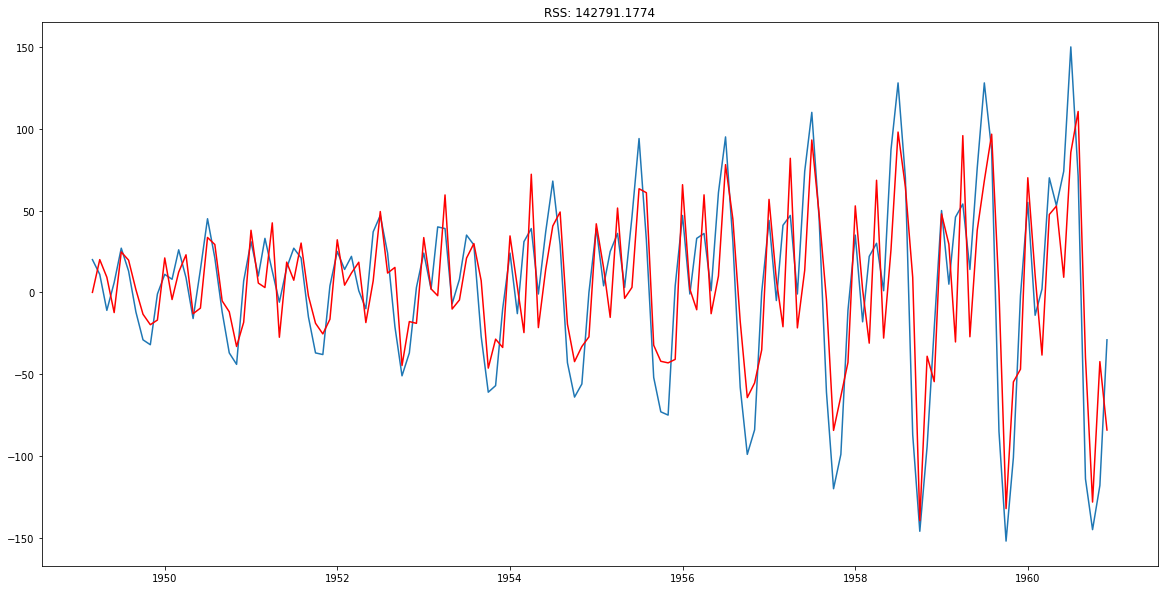

In [43]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_2_diff, order=(2,1,2))
results=model.fit()
print(results.summary())